In [1]:
import functools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import tensorflow as tf

In [2]:
train_data_url="https://storage.googleapis.com/tf-datasets/titanic/train.csv"
test_data_url="https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

In [3]:
train_file_path=tf.keras.utils.get_file('train.csv',train_data_url)
test_file_path=tf.keras.utils.get_file('eval.csv',test_data_url)

In [4]:
train_file_path

'C:\\Users\\personal\\.keras\\datasets\\train.csv'

In [5]:
np.set_printoptions(precision=3,suppress=True)

In [6]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


The system cannot find the path specified.


In [7]:
label_column='survived'
labels=[0,1]

In [8]:
def get_dataset(file_path,**kwargs):
    dataset=tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=5,
        label_name=label_column,
        na_value="?",
        num_epochs=1,
        ignore_errors=True,
        **kwargs)
    return dataset

In [9]:
raw_train_data=get_dataset(train_file_path)
raw_test_data=get_dataset(test_file_path)

In [10]:
def display_batch(dataset):
    for batch,label in dataset.take(1):
        for key,value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))
            

In [11]:
display_batch(raw_train_data)

sex                 : [b'male' b'male' b'male' b'male' b'female']
age                 : [35. 18.  7. 25. 28.]
n_siblings_spouses  : [0 0 4 0 2]
parch               : [0 0 1 0 0]
fare                : [ 8.05   7.775 39.688 13.    23.25 ]
class               : [b'Third' b'Third' b'Third' b'Second' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton' b'Queenstown']
alone               : [b'y' b'y' b'n' b'y' b'n']


In [12]:
csv_columns=['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
temp_dataset=get_dataset(train_file_path,column_names=csv_columns)
display_batch(temp_dataset)

sex                 : [b'male' b'male' b'female' b'male' b'male']
age                 : [19. 28. 40. 11. 38.]
n_siblings_spouses  : [0 0 1 0 0]
parch               : [0 0 1 0 0]
fare                : [ 10.5     7.225 134.5    18.788   7.05 ]
class               : [b'Second' b'Third' b'First' b'Third' b'Third']
deck                : [b'unknown' b'unknown' b'E' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Cherbourg' b'Cherbourg' b'Cherbourg' b'Southampton']
alone               : [b'y' b'y' b'n' b'y' b'y']


In [13]:
select_columns=['survived', 'age', 'n_siblings_spouses', 'class', 'deck', 'alone']
temp_dataset=get_dataset(train_file_path,select_columns=select_columns)
display_batch(temp_dataset)

age                 : [40. 50. 29. 29. 47.]
n_siblings_spouses  : [1 2 1 0 0]
class               : [b'Second' b'First' b'Second' b'First' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'D' b'unknown']
alone               : [b'n' b'n' b'n' b'y' b'y']


In [14]:
select_columns = ['survived', 'age', 'n_siblings_spouses', 'parch', 'fare']
defualts=[0,0.0,0.0,0.0,0.0]
temp_dataset=get_dataset(train_file_path,
                        select_columns=select_columns,
                        column_defaults=defualts)
display_batch(temp_dataset)

age                 : [28.  70.5 22.  39.  28. ]
n_siblings_spouses  : [0. 0. 0. 1. 0.]
parch               : [0. 0. 0. 1. 0.]
fare                : [ 7.787  7.75   9.35  79.65   7.896]


In [15]:
example_batch,labels_batch=next(iter(temp_dataset))

In [16]:
def pack(features,labels):
    return tf.stack(list(features.values()),axis=-1),labels

In [17]:
packed_dataset=temp_dataset.map(pack)

In [18]:
for features,labels in packed_dataset.take(1):
    print(features.numpy())
    print("-----------------------------------")
    print(labels.numpy())

[[18.     1.     1.    20.212]
 [28.     0.     0.     7.225]
 [31.     0.     0.     7.775]
 [35.     0.     0.    26.   ]
 [ 7.     4.     1.    39.688]]
-----------------------------------
[0 1 0 0 0]


In [30]:
class PackNumericFeatures(object):
    def __init__(self,names):
        self.names=names
    def __call__(self,features,labels):
        numeric_features=[features.pop(name) for name in self.names]
        numeric_features=[tf.cast(ft,tf.float32) for ft in numeric_features]
        numeric_features=tf.stack(numeric_features,axis=-1)
        features['numeric']=numeric_features
        return features,labels
        

In [20]:
numeric_features=['age','n_siblings_spouses','parch', 'fare']
packed_train_dataset=raw_train_data.map(PackNumericFeatures(numeric_features))

In [21]:
packed_test_dataset=raw_test_data.map(PackNumericFeatures(numeric_features))

In [22]:
display_batch(packed_train_dataset)

sex                 : [b'male' b'female' b'male' b'male' b'female']
class               : [b'Third' b'First' b'First' b'Third' b'Second']
deck                : [b'unknown' b'D' b'C' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Cherbourg' b'Southampton' b'Southampton']
alone               : [b'y' b'n' b'n' b'n' b'n']
numeric             : [[ 45.      0.      0.      6.975]
 [ 63.      1.      0.     77.958]
 [ 27.      0.      2.    211.5  ]
 [ 10.      3.      2.     27.9  ]
 [  4.      1.      1.     23.   ]]


In [31]:
example_batch,labels_batch=next(iter(packed_train_dataset))
example_batch

OrderedDict([('sex',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'male'], dtype=object)>),
             ('class',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'Third', b'First', b'Third', b'Second'], dtype=object)>),
             ('deck',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'C', b'unknown', b'unknown'], dtype=object)>),
             ('embark_town', <tf.Tensor: shape=(5,), dtype=string, numpy=
              array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
                     b'Southampton'], dtype=object)>),
             ('alone',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y', b'y', b'y', b'y', b'n'], dtype=object)>),
             ('numeric', <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
              array([[36.   ,  0.   ,  0.   ,  7.496],
                     [34.   ,  0.   ,  0.   ,  6.496],
  

In [24]:
import pandas as pd
desb=pd.read_csv(train_file_path)[numeric_features].describe()
desb

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [25]:
mean=np.array(desb.T['mean'])
std=np.array(desb.T['std'])

In [26]:
def normalize_numeric_data(data,mean,std):
    return (data-mean)/std

In [37]:
normalizer=functools.partial(normalize_numeric_data,mean=mean,std=std)
numeric_column=tf.feature_column.numeric_column('numeric',normalizer_fn=normalizer,shape=[len(numeric_features)])
numeric_columns=[numeric_column]
numeric_column

NumericColumn(key='numeric', shape=(4,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x000002B30E5A6048>, mean=array([29.631,  0.545,  0.38 , 34.385]), std=array([12.512,  1.151,  0.793, 54.598])))

In [38]:
example_batch['numeric']

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[36.   ,  0.   ,  0.   ,  7.496],
       [34.   ,  0.   ,  0.   ,  6.496],
       [28.   ,  0.   ,  0.   , 30.5  ],
       [41.   ,  0.   ,  0.   ,  7.125],
       [23.   ,  2.   ,  1.   , 11.5  ]], dtype=float32)>

In [39]:
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch).numpy()

array([[ 0.509, -0.474, -0.479, -0.493],
       [ 0.349, -0.474, -0.479, -0.511],
       [-0.13 , -0.474, -0.479, -0.071],
       [ 0.909, -0.474, -0.479, -0.499],
       [-0.53 ,  1.264,  0.782, -0.419]], dtype=float32)

In [40]:
categories = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

In [43]:
categorical_columns=[]
for feature,vocab in categories.items():
    cat_col=tf.feature_column.categorical_column_with_vocabulary_list(key=feature,vocabulary_list=vocab)
    categorical_columns.append(tf.feature_column.indicator_column(cat_col))

In [44]:
categorical_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [45]:
categorical_layer=tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(example_batch).numpy()[0])

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [46]:
preprocessing_layer=tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)

In [47]:
preprocessing_layer(example_batch).numpy()[0]

array([ 1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.509, -0.474, -0.479, -0.493,  1.   ,  0.   ],
      dtype=float32)

In [53]:
model = tf.keras.Sequential([
          preprocessing_layer,
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(1)])

In [54]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [55]:
train_data=packed_train_dataset.shuffle(500)
test_data=packed_test_dataset

In [56]:
model.fit(train_data,
          validation_data=test_data,
          epochs=30)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
    111/Unknown - 0s 916us/step - loss: 0.5307 - accuracy: 0.7264WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'collections.OrderedDict'> input: OrderedDict([('sex', <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>), ('class', <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>), ('deck', <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>), ('embark_town', <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>), ('alone', <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=string>), ('numeric', <tf.Tensor 'IteratorGetNext:4' shape=(None, 4) dtype=float32>)])
Consider rewriting this model with the Functional API.
126/126 [==============================] - 0s 3ms/step - loss: 0.5221 - accuracy: 0.7352 - val_loss: 0.4615 - val_accuracy: 0.7917
Epoch 2/30
126/126 [=====================

In [57]:
loss=pd.DataFrame(model.history.history)
loss.tail()

,loss,accuracy,val_loss,val_accuracy
25,0.296441,0.859649,0.499950,0.840909
26,0.282101,0.869219,0.488049,0.844697
27,0.288004,0.869219,0.471586,0.844697
28,0.283551,0.872408,0.502266,0.840909
29,0.281718,0.870813,0.521200,0.848485


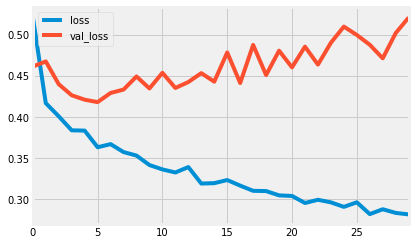

In [58]:
loss[["loss","val_loss"]].plot()

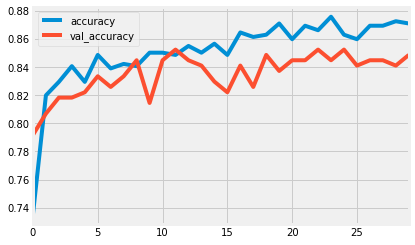

In [59]:
loss[["accuracy","val_accuracy"]].plot()

In [60]:
test_loss,test_accuracy=model.evaluate(test_data)
print(f"loss is {test_loss} and accuracy is {test_accuracy*100}%")

53/53 [==============================] - 0s 960us/step - loss: 0.5212 - accuracy: 0.8485
loss is 0.5211995840072632 and accuracy is 84.84848737716675%


In [63]:
#predictions=model.predict(test_data)
predictions=(model.predict(test_data)>0.5).astype("int32")

In [67]:
test_data

<MapDataset shapes: (OrderedDict([(sex, (None,)), (class, (None,)), (deck, (None,)), (embark_town, (None,)), (alone, (None,)), (numeric, (None, 4))]), (None,)), types: (OrderedDict([(sex, tf.string), (class, tf.string), (deck, tf.string), (embark_town, tf.string), (alone, tf.string), (numeric, tf.float32)]), tf.int32)>

In [88]:
list(test_data)[0][1][:10]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 1, 0, 1])>

In [99]:
pred=model.predict(test_data)
for prediction,survived in zip(pred[:10],list(test_data)[0][1][:10]):
    prediction=tf.sigmoid(prediction).numpy()
    print(f"predicted survival :{prediction[0]*100}%","| Actual outcome : ",("Survived" if bool(survived) else "Died"))
    

predicted survival :8.141198754310608% | Actual outcome :  Died
predicted survival :99.99201893806458% | Actual outcome :  Survived
predicted survival :17.781606316566467% | Actual outcome :  Survived
predicted survival :9.822583198547363% | Actual outcome :  Died
predicted survival :98.36503267288208% | Actual outcome :  Died
